In [1]:
import torch 
import gym
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import sys
import time


N_a = 3                             # number of possible actions (actions are -1, 0, and 1)
sigma = 0.1                         # noise
dim = 2                             # dimensionality of the space (v: R^d --> R)
pCNL = False
obs_min = np.array([-1.2,-0.07])
obs_max = np.array([ 0.6, 0.07])

In [2]:
"""

FUNCTIONS - VALUE FUNCTION AND POLICIES

"""

''' Progress bar to know how much longer one has to wait '''
def progressBar(value, endvalue, bar_length=40):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush() 
    
''' u(x), which evaluates the function u at x=(pos,speed) with the currently set xi '''
def u(x):
    x_transformed = np.zeros(dim)
    for i in range(dim):
        x_transformed[i] = ((x[i]-obs_min[i])/(obs_max[i]-obs_min[i])-1/2)*2
        
    value = model_list[it](torch.from_numpy(x_transformed).float())
    return value

''' Policy from "Reinforcement Learning: Theory and {Python} Implementation" '''
def policy(position,velocity):
        lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
                0.3 * (position + 0.9) ** 4 - 0.008)
        ub = -0.07 * (position + 0.38) ** 2 + 0.07
        if lb < velocity < ub:
            action = 2 # push right
        else:
            action = 0 # push left
        return action

# MAIN PROGRAMME

In [3]:
"""

MAIN PROGRAMME - SHOW LEARNED BEHAVIOUR

"""   
   
env = gym.make('MountainCar-v0')
env = env.unwrapped

failures = np.zeros(3)
steps = [[],[],[]]


'''
Behaviour following the optimal policy
'''
for _ in range(10):
    pos_curr,speed_curr = env.reset()
    for k in range(200):
        pos_curr,speed_curr = env.step(policy(pos_curr,speed_curr))[0] 
        
        if pos_curr>0.5:
            steps[0].append(k)
            break
    if k==199:
        failures[0]+=1
print('Optimal policy done.')
s = 1

Optimal policy done.


In [4]:
method = 'pCN'
N_data = 50

""" initialise NNs - pCN """

model_list = []

# Hyperparameters for our network
input_size = dim
n_layer = 3
hidden_sizes = [10,10,10]
output_size = 1

# Store hyperparameters in string
hyps = str(hidden_sizes[0])
for i in range(1,n_layer):
    hyps = hyps+'_'+str(hidden_sizes[i])

for it in range(1000):
    # Build a feed-forward network
    model_list.append(nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[-1], output_size)))

    # Get weights
    weights = []
    biases = []
    for l in range(n_layer+1):
        weights.append(np.load('np_saved/MC/samples_policy_learning/NN_'+hyps+'_'+method+'_NData'+str(N_data)+'_w'+str(l)+'_sampleNo'+str(it)+'.npy'))
        biases.append(np.load('np_saved/MC/samples_policy_learning/NN_'+hyps+'_'+method+'_NData'+str(N_data)+'_b'+str(l)+'_sampleNo'+str(it)+'.npy'))
        
    # Set all weights to 0
    for l in range(n_layer+1):
        model_list[it][2*l].weight = torch.nn.Parameter(torch.from_numpy(weights[l]).float(), requires_grad=False)
        model_list[it][2*l].bias = torch.nn.Parameter(torch.from_numpy(biases[l]).float(), requires_grad=False)


""" run tests - pCN """

v = np.zeros(N_a)
v_with_noise = np.zeros(N_a)

errors = 0
corrects = 0

print('Test started: ' + str(time.ctime()))
for _ in range(100):
    pos_curr,speed_curr = env.reset()

    for k in range(200):
        progressBar(k+1,200)

        ''' See where different actions would take us, evaluate mean of value function samples there '''
        v = np.zeros(N_a)
        for it in range(1000): # Iterate through different neural networks
            for i in range(N_a):
                x = env.step(i)[0]
                v[i] += u(x).detach().numpy()[0]
                env.state = [pos_curr,speed_curr]
        v = v/1000 # to get mean of value function evaluations

        ''' Pick action which maximises the mean value function (plus noise) at the new location '''
        v_with_noise = v+sigma*np.random.normal(np.zeros(N_a),np.ones(N_a)) 
        a_argmax_with_noise = np.argmax(v_with_noise)

        ''' Check whether learned action is the same as true action would be '''
        if a_argmax_with_noise != policy(pos_curr,speed_curr):
            errors+=1
        else:
            corrects+=1

        pos_curr,speed_curr = env.step(a_argmax_with_noise)[0]

        if pos_curr>0.5:
            steps[s].append(k)
            break
    if k==199:
        failures[s]+=1
    progressBar(200,200)
    print('\n')

print('Errorrate = ',(errors/(errors+corrects))) # Only makes sense if following learned policy
s+=1
print('pCN done, '+ str(time.ctime()))
        
env.close()

Test started: Mon Jul 13 10:24:08 2020
Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [-----------------------

In [5]:
method = 'pCNL'
N_data = 50

""" initialise NNs - pCNL """

model_list = []

# Hyperparameters for our network
input_size = dim
n_layer = 3
hidden_sizes = [10,10,10]
output_size = 1

# Store hyperparameters in string
hyps = str(hidden_sizes[0])
for i in range(1,n_layer):
    hyps = hyps+'_'+str(hidden_sizes[i])

for it in range(1000):
    # Build a feed-forward network
    model_list.append(nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                          nn.Tanh(),
                          nn.Linear(hidden_sizes[-1], output_size)))

    # Get weights
    weights = []
    biases = []
    for l in range(n_layer+1):
        weights.append(np.load('np_saved/MC/samples_policy_learning/NN_'+hyps+'_'+method+'_NData'+str(N_data)+'_w'+str(l)+'_sampleNo'+str(it)+'.npy'))
        biases.append(np.load('np_saved/MC/samples_policy_learning/NN_'+hyps+'_'+method+'_NData'+str(N_data)+'_b'+str(l)+'_sampleNo'+str(it)+'.npy'))
        
    # Set all weights to 0
    for l in range(n_layer+1):
        model_list[it][2*l].weight = torch.nn.Parameter(torch.from_numpy(weights[l]).float(), requires_grad=False)
        model_list[it][2*l].bias = torch.nn.Parameter(torch.from_numpy(biases[l]).float(), requires_grad=False)


""" run tests - pCNL """

v = np.zeros(N_a)
v_with_noise = np.zeros(N_a)

errors = 0
corrects = 0

print('Test started: ' + str(time.ctime()))
for _ in range(100):
    pos_curr,speed_curr = env.reset()

    for k in range(200):
        progressBar(k+1,200)

        ''' See where different actions would take us, evaluate mean of value function samples there '''
        v = np.zeros(N_a)
        for it in range(1000): # Iterate through different neural networks
            for i in range(N_a):
                x = env.step(i)[0]
                v[i] += u(x).detach().numpy()[0]
                env.state = [pos_curr,speed_curr]
        v = v/1000 # to get mean of value function evaluations

        ''' Pick action which maximises the mean value function (plus noise) at the new location '''
        v_with_noise = v+sigma*np.random.normal(np.zeros(N_a),np.ones(N_a)) 
        a_argmax_with_noise = np.argmax(v_with_noise)

        ''' Check whether learned action is the same as true action would be '''
        if a_argmax_with_noise != policy(pos_curr,speed_curr):
            errors+=1
        else:
            corrects+=1

        pos_curr,speed_curr = env.step(a_argmax_with_noise)[0]

        if pos_curr>0.5:
            steps[s].append(k)
            break
    if k==199:
        failures[s]+=1
    progressBar(200,200)
    print('\n')

print('Errorrate = ',(errors/(errors+corrects))) # Only makes sense if following learned policy
s+=1
print('pCNL done, '+ str(time.ctime()))
        
env.close()

Test started: Mon Jul 13 13:11:10 2020
Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [--------------------------------------->] 100%

Percent: [-----------------------

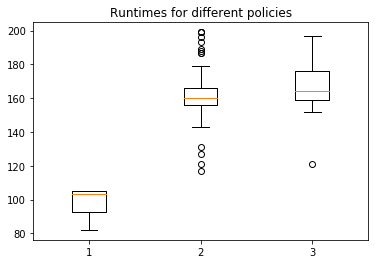

[ 0. 23. 35.]


In [6]:
fig1, ax1 = plt.subplots()
ax1.set_title('Runtimes for different policies')
ax1.boxplot(steps)
plt.show()

print(failures)

np.save('NN_steps.npy',np.array(steps))
np.save('NN_failures.npy',failures)

In [7]:
# N_data=50
# method='pCN'

# mean = [[],[]]
# for l in range(n_layer+1):
#     mean[0].append(np.load('np_saved/MC/NN_'+hyps+'_'+method+'_NData'+str(N_data)+'_lastSample_w'+str(l)+'.npy'))
#     mean[1].append(np.load('np_saved/MC/NN_'+hyps+'_'+method+'_NData'+str(N_data)+'_lastSample_b'+str(l)+'.npy'))

# ''' both pCN and pCNL '''
# for l in range(n_layer+1):
#     model[2*l].weight = torch.nn.Parameter(torch.from_numpy(mean[0][l]).float(), requires_grad=False)
#     model[2*l].bias = torch.nn.Parameter(torch.from_numpy(mean[1][l]).float(), requires_grad=False)
    
# fig, ax = plt.subplots()

# x = np.arange(-1.2,0.6,0.02)
# y = np.arange(-0.07,0.07,0.002)
# X,Y = np.meshgrid(x,y)
# Z = np.zeros(X.shape)
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         Z[i,j] = u((X[i,j],Y[i,j]))[0]

# ax.contourf(X,Y,Z)

# fig.savefig('figs/MC_value_fn.pdf', dpi=300)
# plt.close(fig) 